# Tutorial: Calibrating the age--action model

We know that stellar age is correlated with certain galactic kinematic properties, including the vertical action (J_z). Since we can calculate the vertical action for virtually all stars in the Gaia catalogue with a radial velocity, we can use this information to constrain stellar ages kinematically (even for very-low-mass stars).

In this tutorial, we will calibrate the dynamical stellar age relation using the vertical action calculated from Gaia data, and an independent source of stellar age. Here, we using asteroseismic ages for red giant branch stars. 

### Before running this tutorial, please download and unzip `data.zip` from https://zenodo.org/records/10806816, and move the folder to the current directory. This data is necessary to run the tutorial.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import jax.numpy as jnp

import zoomies

%load_ext autoreload
%autoreload 2

## Stokholm RGB Sample

First, we read in a calibration sample of red giant branch stars with asteroseismic ages, crossmatched with Gaia.

Table from Stokholm et al. 2023 https://ui.adsabs.harvard.edu/abs/2023MNRAS.524.1634S/abstract

In [ ]:
xmatch = Table.read('data/StokholmRGB_GaiaXmatch.csv')

# Getting rid of negative parallaxes
xmatch = xmatch[xmatch['parallax'] > 0]

The function ``calc_jz()`` calculates and saves actions (J_z, J_r, and J_phi) for the calibration stellar sample. The function assumes a Milky Way model from `gala` and wraps the `agama.ActionFinder()` method.

(This step will take a while for large samples)

In [3]:
zoomies.calc_jz(xmatch,  mwmodel='2022', method='agama', write=True, fname='data/StokholmRGB_GaiaXmatch_WithActions_2022.fits')

Read saved table with actions back in:

In [4]:
xmatch = Table.read('data/StokholmRGB_GaiaXmatch_WithActions_2022.fits')

In [5]:
# Filter out Nan Jzs
xmatch = xmatch[~np.isnan(xmatch['Jz'])]

# Filter out unreasonably large Jzs
xmatch = xmatch[np.log(xmatch['Jz']) < 20]

We calculate an age error column from the percentile values given. We don't want any negative or zero age errors.

In [6]:
xmatch['age_err'] = np.nanmean((xmatch['LOWER_ERROR_AGE_BASTA']/1000, xmatch['UPPER_ERROR_AGE_BASTA']/1000), axis=0)
xmatch = xmatch[xmatch['age_err'] > 0]

Write the filtered table again -- now can read in the table without doing any more cuts.

Writing/reading in the tables like this is optional, but it allows you to perform analysis only on the saved tables with calculated actions (without calculating the actions again)

In [7]:
xmatch.write('data/StokholmRGB_GaiaXmatch_WithActions_2022.fits', overwrite=True)

Start from here if you've already done the above steps and saved the table.

In [8]:
xmatch = Table.read('data/StokholmRGB_GaiaXmatch_WithActions_2022.fits')

Defining age, ln(J_z), and age error arrays

In [9]:
age = np.array(xmatch['AGE_BASTA'])/1000 # Age in Gyr
lnJz = np.array(np.log(xmatch['Jz']))
age_err = np.array(xmatch['age_err'])

Plot the calibration sample in age--action space:

Text(0.5, 1.0, 'RGB Calibration Sample')

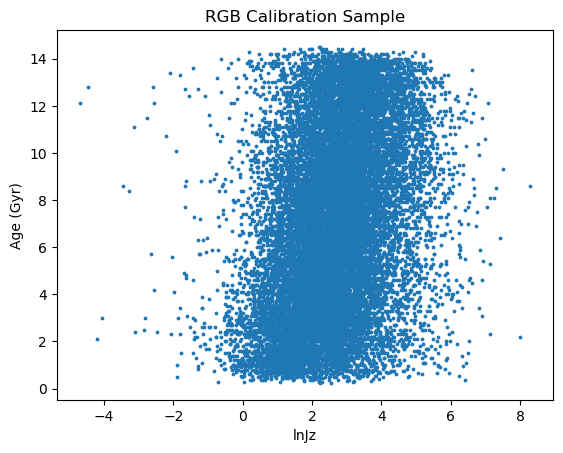

In [10]:
# Calibration sample in age-lnJz space
plt.scatter(lnJz, age, s=3)
plt.xlabel('lnJz')
plt.ylabel('Age (Gyr)')
plt.title('RGB Calibration Sample')

### Calibrating the monotonic age-lnJz spline model

First, define a KinematicAgeSpline object using ``jax`` arrays of the age, age_error, and lnJz variables we defined above:

In [11]:
RGBspline = zoomies.KinematicAgeSpline(jnp.array(lnJz), jnp.array(age), jnp.array(age_err))

With ``spline.fit_mono_spline``, you can fit the age--action model (including a monotonic age--lnJz spline) using the calibration sample in one step. 

In [12]:
RGBspline.fit_mono_spline(num_warmup=2000, num_samples=2000)

Fitting line...


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Let's plot our spline model against the calibration data:

In [13]:
RGBspline.evaluate_spline()

Text(0.5, 1.0, 'Age vs. $ln(J_z)$')

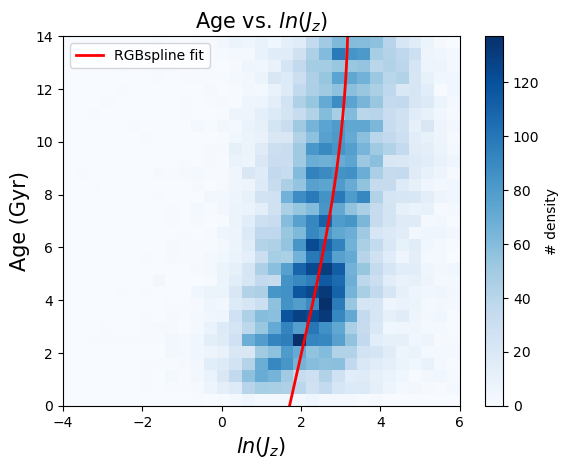

In [14]:
plt.hist2d(RGBspline.lnJz, RGBspline.age, bins=(np.linspace(-4, 6, 32), np.linspace(0, 14, 32)), cmap='Blues')
plt.plot(RGBspline.eval_spline, RGBspline.grid, color='red', label='RGBspline fit', lw=2)

plt.ylabel('Age (Gyr)', fontsize=15);
plt.xlabel('$ln(J_z)$', fontsize=15);
plt.colorbar(label='# density');
plt.legend()
plt.title('Age vs. $ln(J_z)$', fontsize=15)

We can take a look at the sample statistics using ``spline.inf_data``:

In [15]:
import arviz as az
az.summary(RGBspline.inf_data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
V,1.314,0.013,1.291,1.339,0.000,0.000,5446.0,2716.0,1.0
age_knot_vals[0],1.548,0.043,1.466,1.627,0.001,0.001,1667.0,2534.0,1.0
age_knot_vals[1],0.152,0.010,0.132,0.170,0.000,0.000,1491.0,2209.0,1.0
age_knot_vals[2],0.113,0.010,0.095,0.132,0.000,0.000,1617.0,2117.0,1.0
age_knot_vals[3],0.073,0.011,0.051,0.091,0.000,0.000,2404.0,2791.0,1.0
age_knot_vals[4],0.014,0.013,0.000,0.038,0.000,0.000,3246.0,2207.0,1.0
dens_knot_vals[0],-9.726,0.272,-10.000,-9.247,0.004,0.003,3047.0,1915.0,1.0
dens_knot_vals[1],4.699,0.079,4.541,4.839,0.001,0.001,4364.0,3129.0,1.0
dens_knot_vals[2],7.165,0.030,7.108,7.220,0.000,0.000,5305.0,2723.0,1.0
dens_knot_vals[3],7.512,0.024,7.466,7.557,0.000,0.000,6844.0,3491.0,1.0


Let's write the calibrated model:

In [16]:
RGBspline.write(directory='../RGB_spline_model/')

And read it back in just for fun

In [17]:
RGBnewspline = zoomies.read(directory='../RGB_spline_model/')

``RGBnewspline`` has all the same attributes as ``RGBspline``, so you can fit the model once and read it in again and again to generate age predictions for other stars.

In [21]:
RGBnewspline.evaluate_spline()

Text(0.5, 1.0, 'Age vs. $ln(J_z)$')

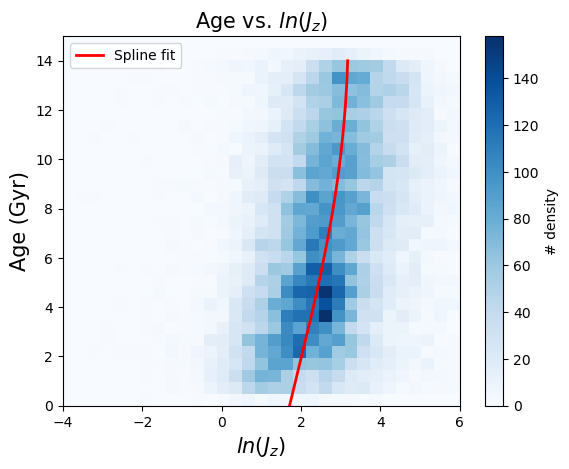

In [22]:
plt.hist2d(RGBnewspline.lnJz, RGBnewspline.age, bins=(np.linspace(-4, 6, 32), np.linspace(0, 15, 32)), cmap='Blues')
plt.plot(RGBnewspline.eval_spline, RGBnewspline.grid, color='red', label='Spline fit', lw=2)

plt.ylabel('Age (Gyr)', fontsize=15);
plt.xlabel('$ln(J_z)$', fontsize=15);
plt.colorbar(label='# density');
plt.legend()
plt.title('Age vs. $ln(J_z)$', fontsize=15)

Using the ``KinematicAgeSpline.evaluate_ages()`` function, you can generate a predicted age probability distribution for any value of ln($J_z$).

``evaluate_ages()`` returns two things:

``eval_grid`` is the test age array upon which the age probabilities are evaluated.

``eval_pdf`` is the kinematic age probability at each point in ``eval_grid``.

Plotting ``eval_pdf`` vs. ``eval_grid`` gives you the kinematic age probability density function.

In [23]:
# evaluate_ages() takes an argument of ln(Jz).

eval_grid, RGBeval_pdf_m3 = RGBnewspline.evaluate_ages(-3)
_, RGBeval_pdf_m1 = RGBnewspline.evaluate_ages(-1)
_, RGBeval_pdf_0 = RGBnewspline.evaluate_ages(0)
_, RGBeval_pdf_1 = RGBnewspline.evaluate_ages(1)
_, RGBeval_pdf_2 = RGBnewspline.evaluate_ages(2)
_, RGBeval_pdf_3 = RGBnewspline.evaluate_ages(3)
_, RGBeval_pdf_4 = RGBnewspline.evaluate_ages(4)
_, RGBeval_pdf_5 = RGBnewspline.evaluate_ages(5)

Text(0.5, 1.0, 'Age Predictions for Test $ln(J_z) Values$')

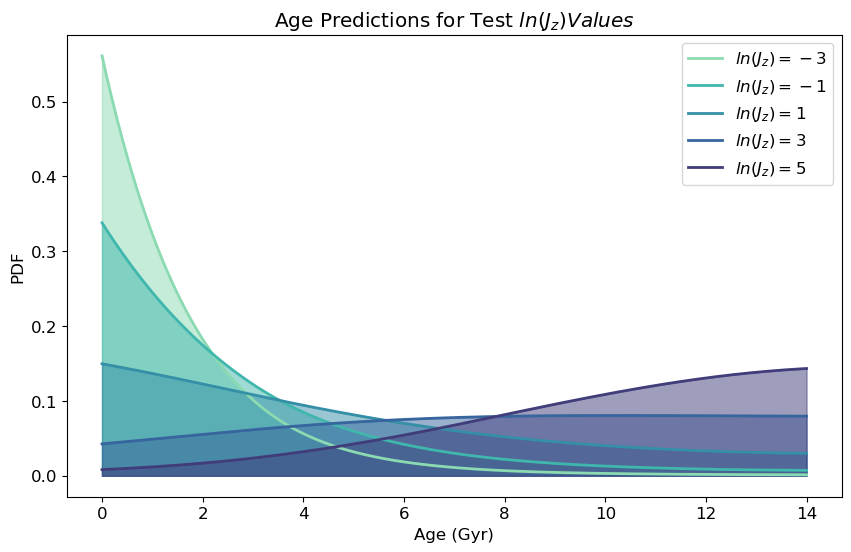

In [24]:
import seaborn as sns

plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['font.size'] = 12

plt.plot(eval_grid, RGBeval_pdf_m3, label='$ln(J_z)=-3$', color=sns.color_palette("mako_r").as_hex()[0], linewidth=2)
plt.plot(eval_grid, RGBeval_pdf_m1, label='$ln(J_z)=-1$', color=sns.color_palette("mako_r").as_hex()[1], linewidth=2)
plt.plot(eval_grid, RGBeval_pdf_1, label='$ln(J_z) = 1 $', color=sns.color_palette("mako_r").as_hex()[2], linewidth=2)
plt.plot(eval_grid, RGBeval_pdf_3, label='$ln(J_z) = 3 $', color=sns.color_palette("mako_r").as_hex()[3], linewidth=2)
plt.plot(eval_grid, RGBeval_pdf_5, label='$ln(J_z) = 5 $', color=sns.color_palette("mako_r").as_hex()[4], linewidth=2)

plt.fill_between(eval_grid, RGBeval_pdf_m3, 0, color=sns.color_palette("mako_r").as_hex()[0], alpha=.5)
plt.fill_between(eval_grid, RGBeval_pdf_m1, 0, color=sns.color_palette("mako_r").as_hex()[1], alpha=.5)
plt.fill_between(eval_grid, RGBeval_pdf_1, 0, color=sns.color_palette("mako_r").as_hex()[2], alpha=.5)
plt.fill_between(eval_grid, RGBeval_pdf_3, 0, color=sns.color_palette("mako_r").as_hex()[3], alpha=.5)
plt.fill_between(eval_grid, RGBeval_pdf_5, 0, color=sns.color_palette("mako_r").as_hex()[4], alpha=.5)

plt.legend()

plt.xlabel('Age (Gyr)')
plt.ylabel('PDF')

plt.title('Age Predictions for Test $ln(J_z) Values$')

Text(0.5, 1.0, 'Age Predictions for Test $ln(J_z) Values$')

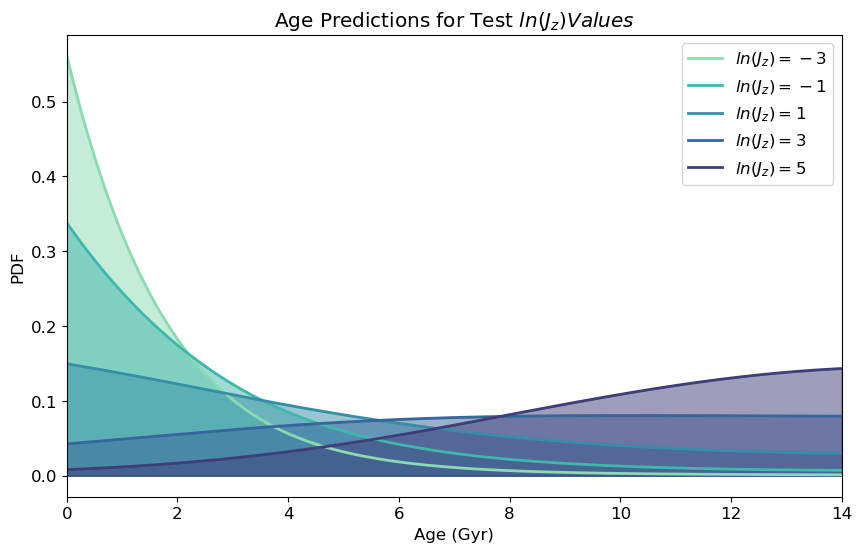

In [25]:
import seaborn as sns

plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['font.size'] = 12

plt.plot(eval_grid, RGBeval_pdf_m3, label='$ln(J_z)=-3$', color=sns.color_palette("mako_r").as_hex()[0], linewidth=2)
plt.plot(eval_grid, RGBeval_pdf_m1, label='$ln(J_z)=-1$', color=sns.color_palette("mako_r").as_hex()[1], linewidth=2)
plt.plot(eval_grid, RGBeval_pdf_1, label='$ln(J_z) = 1 $', color=sns.color_palette("mako_r").as_hex()[2], linewidth=2)
plt.plot(eval_grid, RGBeval_pdf_3, label='$ln(J_z) = 3 $', color=sns.color_palette("mako_r").as_hex()[3], linewidth=2)
plt.plot(eval_grid, RGBeval_pdf_5, label='$ln(J_z) = 5 $', color=sns.color_palette("mako_r").as_hex()[4], linewidth=2)

plt.fill_between(eval_grid, RGBeval_pdf_m3, 0, color=sns.color_palette("mako_r").as_hex()[0], alpha=.5)
plt.fill_between(eval_grid, RGBeval_pdf_m1, 0, color=sns.color_palette("mako_r").as_hex()[1], alpha=.5)
plt.fill_between(eval_grid, RGBeval_pdf_1, 0, color=sns.color_palette("mako_r").as_hex()[2], alpha=.5)
plt.fill_between(eval_grid, RGBeval_pdf_3, 0, color=sns.color_palette("mako_r").as_hex()[3], alpha=.5)
plt.fill_between(eval_grid, RGBeval_pdf_5, 0, color=sns.color_palette("mako_r").as_hex()[4], alpha=.5)

plt.legend()

plt.xlabel('Age (Gyr)')
plt.ylabel('PDF')

plt.xlim(0,14)

plt.title('Age Predictions for Test $ln(J_z) Values$')

## StarHorse APOGEE Sample (MSTO)

Read in data and calculate actions

In [26]:
# Reading calibration sample of MSTO stars with ages, crossmatched with Gaia
starhorse_apogee = Table.read('data/StarHorse_APOGEE_composite.ecsv')
starhorse_apogee = starhorse_apogee[starhorse_apogee['StarHorse_AGE_INOUT'] != 'Warn_diff_inout']

# No negative parallaxes
starhorse_apogee = starhorse_apogee[starhorse_apogee['parallax'] > 0]

# Calculate actions for calibration stars and save
# This step will take a while for large samples
zoomies.calc_jz(starhorse_apogee, mwmodel='2022', method='agama', write=True, fname='data/StarHorse_APOGEE_composite_WithActions_2022.fits')

In [27]:
# Read table back in
starhorse_apogee = Table.read('data/StarHorse_APOGEE_composite_WithActions_2022.fits')

# No Nan Jzs
starhorse_apogee = starhorse_apogee[~np.isnan(starhorse_apogee['Jz'])]

# No Unreasonably large Jzs
starhorse_apogee = starhorse_apogee[np.log(starhorse_apogee['Jz']) < 20]

# Calculate an age error column -- we don't want negative or zero age errors.
starhorse_apogee['age_err'] = np.array(np.nanmean((starhorse_apogee['age50']-starhorse_apogee['age16'], starhorse_apogee['age84']-starhorse_apogee['age50']), axis=0))
starhorse_apogee = starhorse_apogee[starhorse_apogee['age_err'] > 0]

# Write filtered table again -- now can read in the table without doing any more cuts
starhorse_apogee.write('data/StarHorse_APOGEE_composite_WithActions_2022.fits', overwrite=True)

Start from here if you don't want to do all the calculations again

In [28]:
starhorse_apogee = Table.read('data/StarHorse_APOGEE_composite_WithActions_2022.fits')

In [29]:
age = np.array(starhorse_apogee['age50'])
age_err = np.mean((starhorse_apogee['age50'] - starhorse_apogee['age16'], starhorse_apogee['age84'] - starhorse_apogee['age50']), axis=0)
lnJz = np.array(np.log(starhorse_apogee['Jz']))

Text(0.5, 1.0, 'MSTO Calibration Sample')

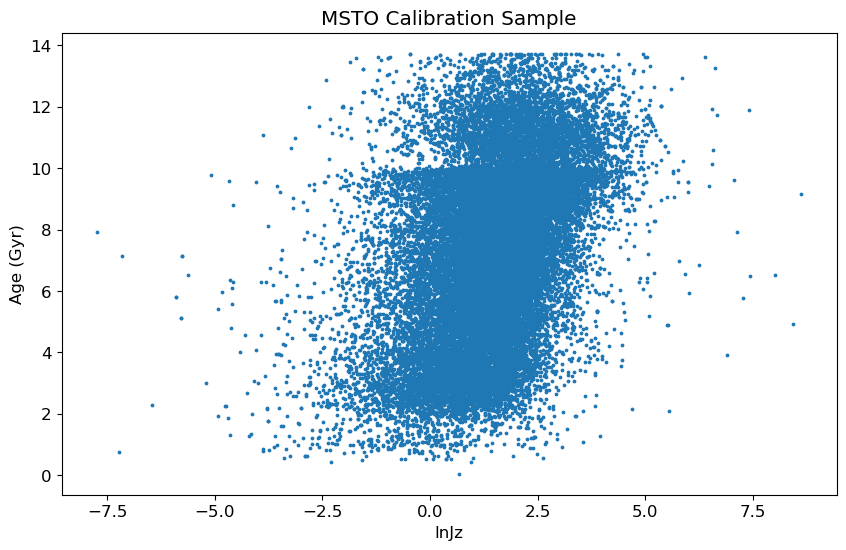

In [30]:
plt.scatter(lnJz, age, s=3)

plt.xlabel('lnJz')
plt.ylabel('Age (Gyr)')

plt.title('MSTO Calibration Sample')

Calibrate monotonic spline model

In [31]:
MSTOspline = zoomies.KinematicAgeSpline(jnp.array(lnJz), jnp.array(age), jnp.array(age_err))
MSTOspline.fit_mono_spline(num_warmup=2000, num_samples=2000)

Fitting line...


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

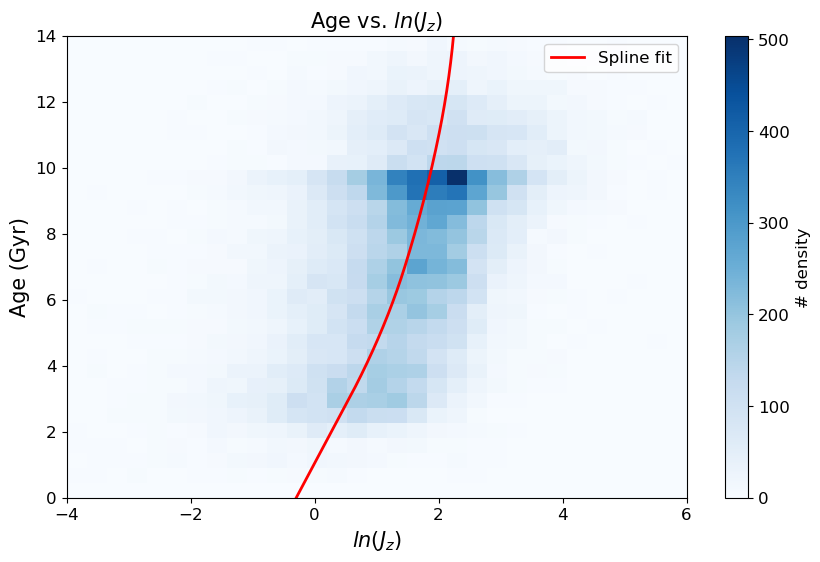

In [32]:
MSTOspline.plot_fit()

In [33]:
import arviz as az
az.summary(MSTOspline.inf_data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
V,1.255,0.009,1.238,1.273,0.000,0.000,4678.0,3122.0,1.0
age_knot_vals[0],-0.631,0.055,-0.735,-0.528,0.001,0.001,2079.0,2624.0,1.0
age_knot_vals[1],0.297,0.012,0.276,0.320,0.000,0.000,1910.0,2432.0,1.0
age_knot_vals[2],0.161,0.008,0.146,0.176,0.000,0.000,1920.0,2508.0,1.0
age_knot_vals[3],0.106,0.010,0.087,0.125,0.000,0.000,2692.0,2426.0,1.0
age_knot_vals[4],0.013,0.013,0.000,0.036,0.000,0.000,2992.0,1896.0,1.0
dens_knot_vals[0],-9.369,0.629,-10.000,-8.188,0.009,0.006,2871.0,1626.0,1.0
dens_knot_vals[1],3.329,0.167,3.012,3.630,0.002,0.002,5073.0,2974.0,1.0
dens_knot_vals[2],5.668,0.051,5.569,5.761,0.001,0.000,5288.0,3183.0,1.0
dens_knot_vals[3],7.612,0.024,7.568,7.657,0.000,0.000,5648.0,3076.0,1.0


In [34]:
MSTOspline.write(directory='../MSTO_spline_model/')

In [35]:
MSTOnewspline = zoomies.read(directory='../MSTO_spline_model/')

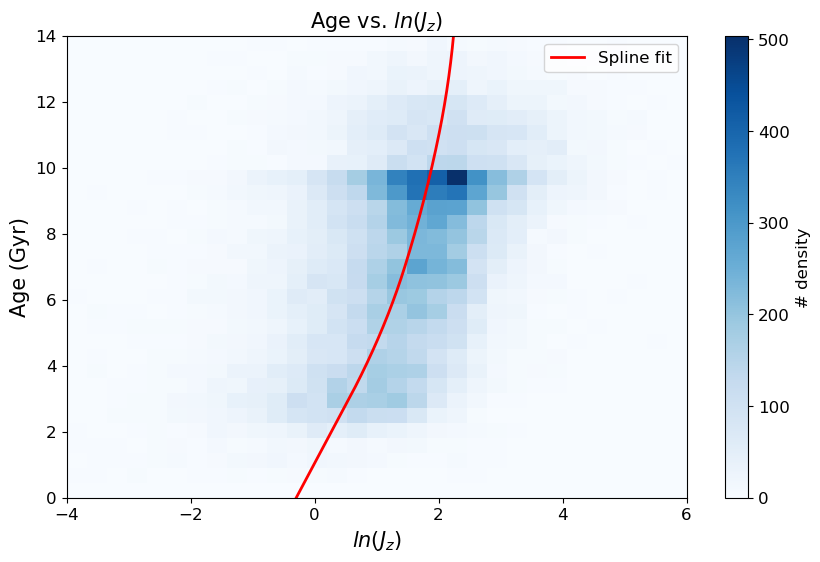

In [36]:
MSTOnewspline.plot_fit()

In [37]:
eval_grid, MSTOeval_pdf_m3 = MSTOnewspline.evaluate_ages(-3)
_, MSTOeval_pdf_m1 = MSTOnewspline.evaluate_ages(-1)
_, MSTOeval_pdf_0 = MSTOnewspline.evaluate_ages(0)
_, MSTOeval_pdf_1 = MSTOnewspline.evaluate_ages(1)
_, MSTOeval_pdf_2 = MSTOnewspline.evaluate_ages(2)
_, MSTOeval_pdf_3 = MSTOnewspline.evaluate_ages(3)
_, MSTOeval_pdf_4 = MSTOnewspline.evaluate_ages(4)
_, MSTOeval_pdf_5 = MSTOnewspline.evaluate_ages(5)

Text(0.5, 1.0, 'Age Predictions for Test $ln(J_z)$ Values: MSTO Calibrated')

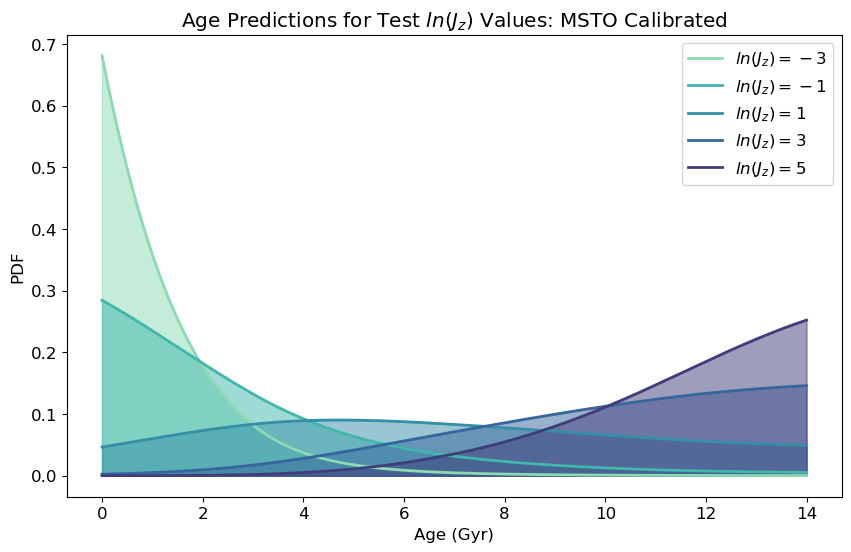

In [38]:
import seaborn as sns

plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['font.size'] = 12

plt.plot(eval_grid, MSTOeval_pdf_m3, label='$ln(J_z)=-3$', color=sns.color_palette("mako_r").as_hex()[0], linewidth=2)
plt.plot(eval_grid, MSTOeval_pdf_m1, label='$ln(J_z)=-1$', color=sns.color_palette("mako_r").as_hex()[1], linewidth=2)
plt.plot(eval_grid, MSTOeval_pdf_1, label='$ln(J_z) = 1 $', color=sns.color_palette("mako_r").as_hex()[2], linewidth=2)
plt.plot(eval_grid, MSTOeval_pdf_3, label='$ln(J_z) = 3 $', color=sns.color_palette("mako_r").as_hex()[3], linewidth=2)
plt.plot(eval_grid, MSTOeval_pdf_5, label='$ln(J_z) = 5 $', color=sns.color_palette("mako_r").as_hex()[4], linewidth=2)

plt.fill_between(eval_grid, MSTOeval_pdf_m3, 0, color=sns.color_palette("mako_r").as_hex()[0], alpha=.5)
plt.fill_between(eval_grid, MSTOeval_pdf_m1, 0, color=sns.color_palette("mako_r").as_hex()[1], alpha=.5)
plt.fill_between(eval_grid, MSTOeval_pdf_1, 0, color=sns.color_palette("mako_r").as_hex()[2], alpha=.5)
plt.fill_between(eval_grid, MSTOeval_pdf_3, 0, color=sns.color_palette("mako_r").as_hex()[3], alpha=.5)
plt.fill_between(eval_grid, MSTOeval_pdf_5, 0, color=sns.color_palette("mako_r").as_hex()[4], alpha=.5)

plt.legend()

plt.xlabel('Age (Gyr)')
plt.ylabel('PDF')

plt.title('Age Predictions for Test $ln(J_z)$ Values: MSTO Calibrated')